In [1]:
from common import colors, sbarlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [3]:
from __future__ import division

import sys
sys.path.append('./analysis/spk_timing/IA_mod')
sys.path.append('./figs/scripts')

import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

import IAmod
from ezephys import pltools

In [4]:
Vin = np.empty((10000, 600))
Vin[:1000, :] = 0
Vin[1000:, :] = 60.2

hi_IA_mod = IAmod.IAmod(10, 1.2, 4)
ohmic_mod = IAmod.IAmod(0, 1.2, 4)

print 'Running simulations.',
hi_IA_sim = IAmod.Simulation(hi_IA_mod, hi_IA_mod.El, Vin)
print '.',
ohmic_sim = IAmod.Simulation(ohmic_mod, ohmic_mod.El, Vin)
print('Done!')

Running simulations. . Done!


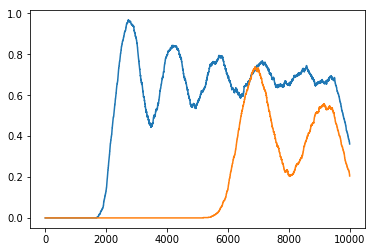

In [5]:
plt.plot(ohmic_sim.PSTH(1))
plt.plot(hi_IA_sim.PSTH(1))

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


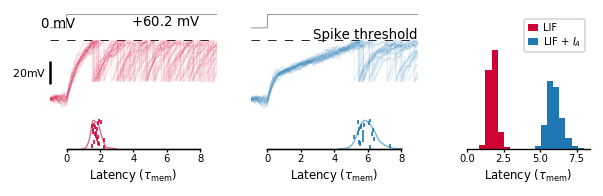

In [6]:
neurons_to_show = 20
hi_IA_color = (0.2, 0.2, 0.9)
low_IA_color = (0.07, 0.07, 0.3)

plt.style.use('./figs/scripts/writeup/publication_figure_style.dms')

IMG_PATH = './figs/ims/defence/'

spec_outer = gs.GridSpec(1, 2, hspace = 0.5, left = 0.05, right = 0.95, top=0.95, bottom=0.2, width_ratios=[3, 1])
spec_traces = gs.GridSpecFromSubplotSpec(3, 2, spec_outer[0, 0], height_ratios=[0.2, 1, 0.4])

plt.figure(figsize = (5, 1.5))

for i, (sim, input_, color) in enumerate([
    (ohmic_sim, Vin, colors['4AP']), 
    (hi_IA_sim, Vin, colors['ser']), 
]):

    in_ax = plt.subplot(spec_traces[0, i])
    plt.plot(
        sim.t_vec,
        input_[:, 0],
        color = 'gray', 
        lw = 0.5
    )
    if i == 0:
        plt.annotate('$0$ mV', (0.5, 2), ha = 'center')
        plt.annotate('$+60.2$ mV', (9, 58), ha = 'right', va = 'top')
        input_ylim = plt.ylim()
    else:
        plt.ylim(input_ylim)
    plt.xlim(sim.t_vec[0], sim.t_vec[-1])
    pltools.hide_border()
    pltools.hide_ticks()

    vtrace_ax = plt.subplot(spec_traces[1, i], sharex = in_ax)
    plt.axhline(-20, color = 'k', lw = 0.5, ls = '--', dashes = (10, 10))
    plt.plot(
        sim.t_vec,
        sim.V[:, :neurons_to_show],
        color = color, lw = 0.5, alpha = 0.1
    )
    plt.xlim(sim.t_vec[0], sim.t_vec[-1])
    if i == 0:
        pltools.add_scalebar(
            y_units = 'mV', 
            y_size=20, 
            omit_x = True, 
            anchor = (0, 0.3), 
            linewidth=sbarlw
        )
        v_ylim = plt.ylim()
    else:
        if i == 1:
            plt.annotate('Spike threshold', (10, -19), ha = 'right')
            
        pltools.hide_border('a')
        pltools.hide_ticks()
        plt.ylim(v_ylim)
    

    raster_ax = plt.subplot(spec_traces[2, i])
    density_ax = raster_ax.twinx()
    sns.kdeplot(
        (sim.get_spk_latencies()[~np.isnan(sim.get_spk_latencies())] - 1).flatten(),
        color=color,
        alpha=0.6,
        ax=density_ax,
    )
    for j in range(neurons_to_show):
        first_spk = 1e-3 * np.min(np.where(sim.spks[:, j])[0])
        raster_ax.plot(
            first_spk - 1,
            j,
            '|', color=color, markersize = 2
        )
    raster_ax.set_xlim(sim.t_vec[0] - 1, sim.t_vec[-1] - 1)
    raster_ax.set_xlabel('Latency ($\\tau_{{\mathrm{{mem}}}}$)')
    raster_ax.set_yticks([])
    density_ax.set_yticks([])
    pltools.hide_border('trl', trim=True, ax=raster_ax)
    pltools.hide_border('trl', trim=True, ax=density_ax)

bins = np.linspace(0, 8, 20)
plt.subplot(spec_outer[0, 1])
plt.hist(
    ohmic_sim.get_spk_latencies()[~np.isnan(ohmic_sim.get_spk_latencies())] - 1,
    edgecolor='none', facecolor=colors['4AP'], bins=bins, label='LIF'
)
plt.hist(
    hi_IA_sim.get_spk_latencies()[~np.isnan(hi_IA_sim.get_spk_latencies())] - 1,
    edgecolor = 'none', facecolor = colors['ser'], bins = bins,
    label = 'LIF + $I_A$'
)
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1] * 1.3)
plt.xlabel('Latency ($\\tau_{{\mathrm{{mem}}}}$)')
pltools.hide_border('ltr')
plt.yticks([])
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))


if IMG_PATH is not None:
    plt.savefig(IMG_PATH + 'IA_jitter_theory.png', bbox_inches='tight')
    plt.savefig(IMG_PATH + 'IA_jitter_theory.svg', bbox_inches='tight')

plt.show()